In [8]:
# Import specific functions
import sys
import numpy as np
from numpy.linalg import eig, inv, pinv, eigvals
from scipy.spatial.distance import squareform, pdist
from scipy.sparse import csr_matrix, random as sparse_random, find, issparse
from scipy.stats import multivariate_normal as mvnpdf
import time
from scipy.spatial.distance import pdist, squareform
from scipy.linalg import inv
import numpy as np
import scipy.sparse as sp
from scipy.spatial.distance import squareform
from scipy.sparse import triu, coo_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, normalized_mutual_info_score
from scipy.sparse.linalg import norm as sparse_norm
from scipy.spatial.distance import squareform
from math import sqrt

sys.path.append('/Users/paul_reitz/Documents/repos/PyAWGLMM/Smooth_AWGLMM')
from scripts.utils import (
    visualize_glmm,
    graph_learning_perf_eval,
    identify_and_compare,
    generate_connected_graph,
    normest,
    lin_map,
    squareform_sp,
    sum_squareform,
    prox_sum_log,
    gsp_distanz,
)


In [9]:

def gsp_learn_graph_log_degrees(Z, a, b, params=None):
    if params is None:
        params = {}
    verbosity = params.get('verbosity', 1)
    maxit = params.get('maxit', 1000)
    tol = params.get('tol', 1e-5)
    step_size = params.get('step_size', 0.5)
    fix_zeros = params.get('fix_zeros', False)
    max_w = params.get('max_w', np.inf)

    w_0 = params.get('w_0', 0)
    if w_0 != 0 and 'c' not in params:
        raise ValueError("When w_0 is specified, c must also be specified")
    c = params.get('c', 0.0 if w_0 == 0 else None)

    # Convert Z to vector form
    if Z.ndim == 2 and Z.shape[0] == Z.shape[1]:
        z = squareform_sp(Z)
    else:
        z = Z
    z = z.ravel()
    l = len(z)
    n = int(round((1 + sqrt(1+8*l))/2))

    if not np.isscalar(w_0):
        # Convert w_0 to vector form if needed
        if w_0.ndim == 2 and w_0.shape[0] == w_0.shape[1]:
            w_0 = squareform_sp(w_0)
        w_0 = w_0.ravel()
    else:
        w_0 = float(w_0)

    if fix_zeros:
        edge_mask = params.get('edge_mask', None)
        if edge_mask is None:
            raise ValueError("edge_mask must be provided when fix_zeros is True")
        if edge_mask.ndim == 2 and edge_mask.shape[0] == edge_mask.shape[1]:
            edge_mask = squareform_sp(edge_mask)
        edge_mask = edge_mask.ravel()
        ind = np.flatnonzero(edge_mask)
        z = z[ind].astype(float)
        if not np.isscalar(w_0):
            w_0 = w_0[ind].astype(float)
    else:
        z = z.astype(float)
        if not np.isscalar(w_0):
            w_0 = w_0.astype(float)

    w = params.get('W_init', np.zeros_like(z, dtype=float))

    # Construct S, St
    if fix_zeros:
        S, St = sum_squareform(n, edge_mask)
    else:
        S, St = sum_squareform(n)

    K_op = lambda w_: S.dot(w_)
    Kt_op = lambda z_: St.dot(z_)

    if fix_zeros:
        # Estimate norm_K
        x_test = np.random.randn(S.shape[1])
        for _ in range(5):
            x_test = St.dot(S.dot(x_test))
            norm_est = np.linalg.norm(x_test)
            if norm_est == 0:
                break
            x_test = x_test / norm_est
        norm_K = sqrt(norm_est)
    else:
        norm_K = sqrt(2*(n-1))

    def f_eval(w_):
        return 2*np.dot(w_, z)
    def f_prox(w_, c_):
        return np.minimum(max_w, np.maximum(0, w_ - 2*c_*z))

    def g_eval(x):
        # Check if x has non-positive values
        if np.any(x <= 0):
            return np.inf
        return -a * np.sum(np.log(x))

    def g_prox(z_, c_):
        sol, _ = prox_sum_log(z_, c_*a, param={'verbose':0})
        return sol

    def g_star_prox(z_, c_):
        z_ = np.asarray(z_, dtype=float)
        # If z_/(c_*a) not positive, prox_sum_log will report inf and handle gracefully
        sol, _ = prox_sum_log(z_/(c_*a), 1/(c_*a), param={'verbose':0})
        return z_ - c_*a * sol

    if w_0 == 0:
        def h_eval(w_):
            return b*np.sum(w_**2)
        def h_grad(w_):
            return 2*b*w_
        h_beta = 2*b
    else:
        def h_eval(w_):
            return b*np.sum(w_**2) + c*np.sum((w_-w_0)**2)
        def h_grad(w_):
            return 2*((b+c)*w_ - c*w_0)
        h_beta = 2*(b+c)

    mu = h_beta + norm_K
    epsilon = lin_map(0.0, [0, 1/(1+mu)], [0,1])
    gn = lin_map(step_size, [epsilon, (1-epsilon)/mu], [0,1])

    v_n = K_op(w)

    stat = {}
    if verbosity > 1:
        stat['f_eval'] = np.full(maxit, np.nan)
        stat['g_eval'] = np.full(maxit, np.nan)
        stat['h_eval'] = np.full(maxit, np.nan)
        stat['fgh_eval'] = np.full(maxit, np.nan)
        stat['pos_violation'] = np.full(maxit, np.nan)
        print('Relative change of primal, dual variables, and objective fun')

    t0 = time.time()
    for i in range(maxit):
        Y_n = w - gn*(h_grad(w) + Kt_op(v_n))
        y_n = v_n + gn*(K_op(w))

        P_n = f_prox(Y_n, gn)
        p_n = g_star_prox(y_n, gn)
        Q_n = P_n - gn*(h_grad(P_n) + Kt_op(p_n))
        q_n = p_n + gn*(K_op(P_n))

        if verbosity > 2:
            stat['f_eval'][i] = f_eval(w)
            val_g = g_eval(K_op(w))
            stat['g_eval'][i] = val_g
            stat['h_eval'][i] = h_eval(w)
            # If val_g is inf, fgh_eval might be inf as well, which is acceptable
            stat['fgh_eval'][i] = stat['f_eval'][i] + stat['g_eval'][i] + stat['h_eval'][i]
            stat['pos_violation'][i] = -np.sum(np.minimum(0,w))

        denom_w = np.linalg.norm(w)
        if denom_w < 1e-15:
            denom_w = 1e-15
        denom_v = np.linalg.norm(v_n)
        if denom_v < 1e-15:
            denom_v = 1e-15

        rel_norm_primal = np.linalg.norm(-Y_n + Q_n)/denom_w
        rel_norm_dual = np.linalg.norm(-y_n + q_n)/denom_v

        if verbosity > 1 and verbosity <= 3:
            print(f'iter {i+1:4d}: {rel_norm_primal:6.4e}   {rel_norm_dual:6.4e}')

        w = w - Y_n + Q_n
        v_n = v_n - y_n + q_n

        if rel_norm_primal < tol and rel_norm_dual < tol:
            break

    stat['time'] = time.time() - t0
    if verbosity > 0:
        obj_val = f_eval(w) + g_eval(K_op(w)) + h_eval(w)
        print(f'# iters: {i+1:4d}. Rel primal: {rel_norm_primal:6.4e} Rel dual: {rel_norm_dual:6.4e}  OBJ {obj_val:6.3e}')
        print(f'Time needed is {stat["time"]} seconds')

    if fix_zeros:
        full_w = np.zeros(l, dtype=float)
        full_w[ind] = w
        w = full_w

    if Z.ndim == 2 and Z.shape[0] == Z.shape[1]:
        W = squareform_sp(w)
    else:
        W = w

    return W, stat

In [10]:

# # def gsp_learn_graph_log_degrees(Z, a, b, params=None):
# #     if params is None:
# #         params = {}
# #     verbosity = params.get('verbosity', 1)
# #     maxit = params.get('maxit', 1000)
# #     tol = params.get('tol', 1e-5)
# #     step_size = params.get('step_size', 0.5)
# #     fix_zeros = params.get('fix_zeros', False)
# #     max_w = params.get('max_w', np.inf)

# #     w_0 = params.get('w_0', 0)
# #     if w_0 != 0 and 'c' not in params:
# #         raise ValueError("When w_0 is specified, c must also be specified")
# #     c = params.get('c', 0.0 if w_0 == 0 else None)

# #     # Convert Z to vector form
# #     if Z.ndim == 2 and Z.shape[0] == Z.shape[1]:
# #         z = squareform_sp(Z)
# #     else:
# #         z = Z
# #     z = z.ravel()
# #     l = len(z)
# #     n = int(round((1 + sqrt(1+8*l))/2))

# #     if not np.isscalar(w_0):
# #         # Convert w_0 to vector form if needed
# #         if w_0.ndim == 2 and w_0.shape[0] == w_0.shape[1]:
# #             w_0 = squareform_sp(w_0)
# #         w_0 = w_0.ravel()
# #     else:
# #         w_0 = float(w_0)

# #     if fix_zeros:
# #         edge_mask = params.get('edge_mask', None)
# #         if edge_mask is None:
# #             raise ValueError("edge_mask must be provided when fix_zeros is True")
# #         if edge_mask.ndim == 2 and edge_mask.shape[0] == edge_mask.shape[1]:
# #             edge_mask = squareform_sp(edge_mask)
# #         edge_mask = edge_mask.ravel()
# #         ind = np.flatnonzero(edge_mask)
# #         z = z[ind].astype(float)
# #         if not np.isscalar(w_0):
# #             w_0 = w_0[ind].astype(float)
# #     else:
# #         z = z.astype(float)
# #         if not np.isscalar(w_0):
# #             w_0 = w_0.astype(float)

# #     w = params.get('W_init', np.zeros_like(z, dtype=float))

# #     # Construct S, St
# #     if fix_zeros:
# #         S, St = sum_squareform(n, edge_mask)
# #     else:
# #         S, St = sum_squareform(n)

# #     K_op = lambda w_: S.dot(w_)
# #     Kt_op = lambda z_: St.dot(z_)

# #     if fix_zeros:
# #         # Estimate norm_K (optional advanced method)
# #         x_test = np.random.randn(S.shape[1])
# #         for _ in range(5):
# #             x_test = St.dot(S.dot(x_test))
# #             norm_est = np.linalg.norm(x_test)
# #             if norm_est == 0:
# #                 break
# #             x_test = x_test / norm_est
# #         norm_K = sqrt(norm_est)
# #     else:
# #         norm_K = sqrt(2*(n-1))

# #     # Define f, g, h
# #     def f_eval(w_):
# #         return 2*np.dot(w_, z)
# #     def f_prox(w_, c_):
# #         return np.minimum(max_w, np.maximum(0, w_ - 2*c_*z))

# #     def g_eval(x):
# #         return -a * np.sum(np.log(x))
# #     def g_prox(z_, c_):
# #         return prox_sum_log(z_, c_*a)

# #     def g_star_prox(z_, c_):
# #         # Ensure z_ is array:
# #         z_ = np.asarray(z_, dtype=float)
# #         # c_ and a are already floats, so no issue
# #         # Ensure prox_sum_log returns a numpy array as well
# #         return z_ - c_*a * prox_sum_log(z_/(c_*a), 1/(c_*a))[0]


# #     if w_0 == 0:
# #         def h_eval(w_):
# #             return b*np.sum(w_**2)
# #         def h_grad(w_):
# #             return 2*b*w_
# #         h_beta = 2*b
# #     else:
# #         def h_eval(w_):
# #             return b*np.sum(w_**2) + c*np.sum((w_-w_0)**2)
# #         def h_grad(w_):
# #             return 2*((b+c)*w_ - c*w_0)
# #         h_beta = 2*(b+c)

# #     mu = h_beta + norm_K
# #     epsilon = lin_map(0.0, [0, 1/(1+mu)], [0,1])
# #     gn = lin_map(step_size, [epsilon, (1-epsilon)/mu], [0,1])

# #     v_n = K_op(w)

# #     stat = {}
# #     if verbosity > 1:
# #         stat['f_eval'] = np.full(maxit, np.nan)
# #         stat['g_eval'] = np.full(maxit, np.nan)
# #         stat['h_eval'] = np.full(maxit, np.nan)
# #         stat['fgh_eval'] = np.full(maxit, np.nan)
# #         stat['pos_violation'] = np.full(maxit, np.nan)
# #         print('Relative change of primal, dual variables, and objective fun')

# #     import time
# #     t0 = time.time()
# #     for i in range(maxit):
# #         Y_n = w - gn*(h_grad(w) + Kt_op(v_n))
# #         y_n = v_n + gn*(K_op(w))

# #         P_n = f_prox(Y_n, gn)
# #         p_n = g_star_prox(y_n, gn)
# #         Q_n = P_n - gn*(h_grad(P_n) + Kt_op(p_n))
# #         q_n = p_n + gn*(K_op(P_n))

# #         if verbosity > 2:
# #             stat['f_eval'][i] = f_eval(w)
# #             stat['g_eval'][i] = g_eval(K_op(w))
# #             stat['h_eval'][i] = h_eval(w)
# #             stat['fgh_eval'][i] = stat['f_eval'][i] + stat['g_eval'][i] + stat['h_eval'][i]
# #             stat['pos_violation'][i] = -np.sum(np.minimum(0,w))

# #         denom_w = np.linalg.norm(w)
# #         if denom_w < 1e-15:
# #             denom_w = 1e-15
# #         denom_v = np.linalg.norm(v_n)
# #         if denom_v < 1e-15:
# #             denom_v = 1e-15

# #         rel_norm_primal = np.linalg.norm(-Y_n + Q_n)/denom_w
# #         rel_norm_dual = np.linalg.norm(-y_n + q_n)/denom_v

# #         if verbosity > 3:
# #             print(f'iter {i+1:4d}: {rel_norm_primal:6.4e}   {rel_norm_dual:6.4e}   {stat["fgh_eval"][i]:6.3e}')
# #         elif verbosity > 2:
# #             print(f'iter {i+1:4d}: {rel_norm_primal:6.4e}   {rel_norm_dual:6.4e}   {stat["fgh_eval"][i]:6.3e}')
# #         elif verbosity > 1:
# #             print(f'iter {i+1:4d}: {rel_norm_primal:6.4e}   {rel_norm_dual:6.4e}')

# #         w = w - Y_n + Q_n
# #         v_n = v_n - y_n + q_n

# #         if rel_norm_primal < tol and rel_norm_dual < tol:
# #             break

# #     stat['time'] = time.time() - t0
# #     if verbosity > 0:
# #         obj_val = f_eval(w) + g_eval(K_op(w)) + h_eval(w)
# #         print(f'# iters: {i+1:4d}. Rel primal: {rel_norm_primal:6.4e} Rel dual: {rel_norm_dual:6.4e}  OBJ {obj_val:6.3e}')
# #         print(f'Time needed is {stat["time"]} seconds')

# #     if fix_zeros:
# #         full_w = np.zeros(l, dtype=float)
# #         full_w[ind] = w
# #         w = full_w

# #     if Z.ndim == 2 and Z.shape[0] == Z.shape[1]:
# #         W = squareform_sp(w)
# #     else:
# #         W = w

# #     return W, stat

# # ===== TESTING THE FUNCTION =====
# if __name__ == "__main__":
#     # Create a small test scenario
#     np.random.seed(42)
#     n = 5
#     coords = np.random.rand(n,2)
#     Z_dense = np.sum((coords[:,None,:] - coords[None,:,:])**2, axis=2)
#     np.fill_diagonal(Z_dense, 0)

#     # Attempt to learn the graph
#     W, stat = gsp_learn_graph_log_degrees(Z_dense, a=1.0, b=1.0, params={'verbosity':2, 'maxit':200})

#     print("Learned graph W:\n", W.toarray() if hasattr(W, 'toarray') else W)
#     if 'f_eval' in stat and not np.all(np.isnan(stat['f_eval'])):
#         last_idx = np.where(~np.isnan(stat['f_eval']))[0][-1]
#         final_obj = stat['f_eval'][last_idx] + stat['g_eval'][last_idx] + stat['h_eval'][last_idx]
#         print("Final Objective Value:", final_obj)

## Test 2 funcs

In [11]:

# def gsp_learn_graph_log_degrees(Z, a, b, params=None):
#     """
#     Learns a graph structure by optimizing a log-degrees model.

#     Parameters:
#     -----------
#     Z : array-like
#         Input data matrix or condensed distance matrix (squared pairwise distances).

#     a : float
#         Coefficient for the logarithmic penalty term (controls connectivity).

#     b : float
#         Regularization coefficient (controls sparsity).

#     params : dict, optional
#         A dictionary of optional parameters:
#         - 'verbosity': int, level of verbosity (default: 1)
#         - 'maxit': int, maximum number of iterations (default: 1000)
#         - 'tol': float, tolerance for convergence (default: 1e-5)
#         - 'step_size': float, step size for the gradient descent (default: 0.5)
#         - 'max_w': float, maximum allowable weight (default: np.inf)
#         - 'w_0': array-like or int, initial weight matrix or value (default: 0)
#         - 'c': float, regularization coefficient for initial weight matrix
#         - 'fix_zeros': bool, whether to fix zeros in the weight matrix (default: False)
#         - 'edge_mask': array-like, mask for fixed edges (required if 'fix_zeros' is True)

#     Returns:
#     --------
#     W : array-like
#         The learned weight matrix (n x n).

#     stat : dict
#         Output statistics including convergence information.

#     Raises:
#     -------
#     ValueError
#         If 'params.w_0' is specified but 'params.c' is not, or if 'params.edge_mask' is required but not provided.
#     """
#     # Default parameters
#     if params is None:
#         params = {}

#     verbosity = params.get('verbosity', 1)
#     maxit = params.get('maxit', 1000)
#     tol = params.get('tol', 1e-5)
#     step_size = params.get('step_size', 0.5)
#     fix_zeros = params.get('fix_zeros', False)
#     max_w = params.get('max_w', np.inf)
#     w_0 = params.get('w_0', 0)

#     # Initialize z
#     if isinstance(Z, np.ndarray) and Z.ndim == 1:
#         z = Z.copy()
#     else:
#         z = squareform_sp(Z)

#     z = z.flatten()
#     z = np.asarray(z, dtype=float)  # Ensure z is a NumPy array of floats
#     l = len(z)
#     n = int(round((1 + np.sqrt(1 + 8 * l)) / 2))  # Number of nodes

#     # Handle w_0
#     if not np.isscalar(w_0) or w_0 != 0:
#         if 'c' not in params:
#             raise ValueError('When params["w_0"] is specified, params["c"] should also be specified.')
#         else:
#             c = params['c']
#         if isinstance(w_0, np.ndarray) and w_0.ndim == 1:
#             w_0 = w_0.copy()
#         else:
#             w_0 = squareform_sp(w_0)
#         w_0 = w_0.flatten()
#         w_0 = np.asarray(w_0, dtype=float)
#     else:
#         w_0 = 0
#         c = 0  # Ensure c is defined

#     # Handle fix_zeros
#     if fix_zeros:
#         if 'edge_mask' not in params:
#             raise ValueError('When params["fix_zeros"] is True, params["edge_mask"] must be provided.')
#         edge_mask = params['edge_mask']
#         if not isinstance(edge_mask, np.ndarray) or edge_mask.ndim != 1:
#             edge_mask = squareform_sp(edge_mask)
#         ind = np.nonzero(edge_mask.flatten())[0]
#         z = z[ind]
#         if not np.isscalar(w_0):
#             w_0 = w_0[ind]
#     else:
#         edge_mask = None

#     # Initialize w
#     w = np.zeros_like(z)

#     # Needed operators
#     if fix_zeros:
#         S, St = sum_squareform(n, edge_mask)
#     else:
#         S, St = sum_squareform(n)

#     K_op = lambda w: S @ w
#     Kt_op = lambda z: St @ z

#     if fix_zeros:
#         norm_K = sparse_norm(S, ord=2)
#     else:
#         norm_K = np.sqrt(2 * (n - 1))

#     # Define functions f, g, h
#     f_eval = lambda w: 2 * np.dot(w, z)
#     f_prox = lambda w, c: np.minimum(max_w, np.maximum(0, w - 2 * c * z))

#     param_prox_log = {'verbose': verbosity - 3}
#     g_eval = lambda s: -a * np.sum(np.log(s))
#     # g_star_prox = lambda z_in, c_in: z_in - c_in * a * prox_sum_log(z_in / (c_in * a), 1 / (c_in * a), param_prox_log)
#     # g_star_prox = lambda z_in, c_in: np.asarray(z_in) - c_in * a * prox_sum_log(np.asarray(z_in) / (c_in * a), 1 / (c_in * a), param_prox_log)
#     g_star_prox = lambda z, c: z - c * a * prox_sum_log(z / (c * a), 1 / (c * a), param_prox_log)[0]


#     # Corrected h_eval and h_grad with division by 2
#     if np.all(w_0 == 0):
#         # No prior W0
#         h_eval = lambda w: (b / 2) * np.linalg.norm(w) ** 2
#         h_grad = lambda w: b * w
#         h_beta = b  # Lipschitz constant of h_grad
#     else:
#         # With prior W0
#         h_eval = lambda w: (b / 2) * np.linalg.norm(w) ** 2 + (c / 2) * np.linalg.norm(w - w_0) ** 2
#         h_grad = lambda w: b * w + c * (w - w_0)
#         h_beta = b + c  # Lipschitz constant of h_grad

#     # Parameters for convergence
#     mu = h_beta + norm_K
#     epsilon = 1e-6  # A small positive value
#     gn = (1 - epsilon) / mu  # Step size in (epsilon, (1 - epsilon)/mu)

#     # Initialize variables
#     v_n = K_op(w)

#     stat = {}
#     if verbosity > 1:
#         stat['f_eval'] = []
#         stat['g_eval'] = []
#         stat['h_eval'] = []
#         stat['fgh_eval'] = []
#         stat['pos_violation'] = []

#     start_time = time.time()

#     # Iterative optimization
#     for i in range(maxit):
#         # Primal and dual updates
#         Y_n = w - gn * (h_grad(w) + Kt_op(v_n))
#         y_n = v_n + gn * K_op(w)
#         P_n = f_prox(Y_n, gn)
#         p_n = g_star_prox(y_n, gn)
#         Q_n = P_n - gn * (h_grad(P_n) + Kt_op(p_n))
#         q_n = p_n + gn * K_op(P_n)

#         # Compute relative norms
#         rel_norm_primal = np.linalg.norm(-Y_n + Q_n) / (np.linalg.norm(w) + 1e-10)
#         rel_norm_dual = np.linalg.norm(-y_n + q_n) / (np.linalg.norm(v_n) + 1e-10)

#         if verbosity > 1:
#             # Record statistics
#             stat['f_eval'].append(f_eval(w))
#             stat['g_eval'].append(g_eval(K_op(w)))
#             stat['h_eval'].append(h_eval(w))
#             stat['fgh_eval'].append(stat['f_eval'][-1] + stat['g_eval'][-1] + stat['h_eval'][-1])
#             stat['pos_violation'].append(-np.sum(np.minimum(0, w)))
#             print(f'iter {i+1:4d}: {rel_norm_primal:6.4e}   {rel_norm_dual:6.4e}   OBJ {stat["fgh_eval"][-1]:6.3e}')

#         # Update variables
#         w = w - Y_n + Q_n
#         v_n = v_n - y_n + q_n

#         # Check convergence
#         if rel_norm_primal < tol and rel_norm_dual < tol:
#             break

#     total_time = time.time() - start_time
#     if verbosity > 0:
#         final_obj = f_eval(w) + g_eval(K_op(w)) + h_eval(w)
#         print(f'# iters: {i+1:4d}. Rel primal: {rel_norm_primal:6.4e} Rel dual: {rel_norm_dual:6.4e}  OBJ {final_obj:6.3e}')
#         print(f'Time needed is {total_time} seconds')

#     # Reconstruct full weight vector if fix_zeros was used
#     if fix_zeros:
#         w_full = np.zeros(l)
#         w_full[ind] = w
#         w = w_full

#     # Convert vectorized weights back to matrix form
#     if isinstance(Z, np.ndarray) and Z.ndim == 1:
#         W = w
#     else:
#         W = squareform(w)

#     stat['time'] = total_time

#     return W, stat


In [12]:

# # ===== TESTING THE FUNCTION =====
# if __name__ == "__main__":
#     # Create a small test scenario
#     np.random.seed(42)
#     n = 5
#     coords = np.random.rand(n,2)
#     Z_dense = np.sum((coords[:,None,:] - coords[None,:,:])**2, axis=2)
#     np.fill_diagonal(Z_dense, 0)

#     # Attempt to learn the graph
#     W, stat = gsp_learn_graph_log_degrees(Z_dense, a=1.0, b=1.0, params={'verbosity':2, 'maxit':200})

#     print("Learned graph W:\n", W.toarray() if hasattr(W, 'toarray') else W)
#     if 'f_eval' in stat and not np.all(np.isnan(stat['f_eval'])):
#         last_idx = np.where(~np.isnan(stat['f_eval']))[0][-1]
#         final_obj = stat['f_eval'][last_idx] + stat['g_eval'][last_idx] + stat['h_eval'][last_idx]
#         print("Final Objective Value:", final_obj)

In [13]:


def glmm(y, iterations, classes, spread=0.1, regul=0.15, norm_par=1.5):
    """
    Implements a Graph Laplacian Mixture Model (GLMM) 

    Parameters:
    -----------
    y : np.ndarray
        The input data matrix of shape (m, n) where m is the number of signals
        and n is the number of features.
    
    iterations : int
        The number of iterations for the algorithm.
    
    classes : int
        The number of clusters (classes).
    
    spread : float, optional
        Spread parameter for initializing the Laplacian matrices (default: 0.1).
    
    regul : float, optional
        Regularization parameter for the covariance matrices (default: 0.15).
    
    norm_par : float, optional
        Normalization parameter for the distance computation (default: 1.5).

    Returns:
    --------
    L : np.ndarray
        The learned Laplacian matrices of shape (n, n, classes).
    
    gamma_hat : np.ndarray
        The cluster probabilities of shape (m, classes).
    
    mu : np.ndarray
        The cluster means of shape (n, classes).
    
    log_likelihood : np.ndarray
        The log-likelihood values over the iterations.

    Raises:
    -------
    ValueError
        If the dimensions of the input data are not correct.
    """
    
    delta = 2
    n = y.shape[1]
    m = y.shape[0]

    # Initialize variables
    L = np.zeros((n, n, classes))
    W = np.zeros((n, n, classes))
    sigma = np.zeros((n-1, n-1, classes))
    mu = np.zeros((n, classes))
    gamma_hat = np.zeros((m, classes))
    p = np.zeros(classes)
    vecl = np.zeros((n, n, classes))
    vall = np.zeros((n, n, classes))
    yl = np.zeros((m, n-1, classes))
    log_likelihood = np.zeros(iterations)

    for cls in range(classes):
        L[:, :, cls] = spread * np.eye(n) - spread / n * np.ones((n, n))
        mu_curr = np.mean(y, axis=0) + np.random.randn(n) * np.std(y, axis=0)
        mu[:, cls] = mu_curr - np.mean(mu_curr)
        p[cls] = 1 / classes

    # Start the algorithm
    for it in range(iterations):
        # Expectation step
        pall = 0
        for cls in range(classes):
            # vecl[:, :, cls], vall[:, :, cls] = eig(L[:, :, cls])
            eig_vals, eig_vecs = np.linalg.eig(L[:, :, cls])
            eig_vecs = np.real(eig_vecs)
            eig_vals = np.real(eig_vals)
            eig_vals[eig_vals < 0] = 1e-5
            vall[:, :, cls] = np.diag(eig_vals)
            vecl[:, :, cls] = eig_vecs
            sigma[:, :, cls] = inv(vall[1:n, 1:n, cls] + regul * np.eye(n-1))  
            sigma[:, :, cls] = (sigma[:, :, cls] + sigma[:, :, cls].T) / 2
            yl[:, :, cls] = (y - mu[:, cls].T) @ vecl[:, 1:n, cls]
            pall += p[cls] * mvnpdf.pdf(yl[:, :, cls], mean=np.zeros(n-1), cov=sigma[:, :, cls], allow_singular=True)

        # Compute cluster probabilities gamma_hat  
        pall[pall == 0] = 0.1
        for cls in range(classes):
            gamma_hat[:, cls] = (p[cls] * mvnpdf.pdf(yl[:, :, cls], mean=np.zeros(n-1), cov=sigma[:, :, cls])) / pall

        log_likelihood[it] = np.sum(np.log(pall))

        # Maximization step: update mu, W, and p
        for cls in range(classes):
            mu[:, cls] = (gamma_hat[:, cls].T @ y) / np.sum(gamma_hat[:, cls])
            # yc = repmat(np.sqrt(gamma_hat[:, cls])[:, np.newaxis], 1, n) * (y - mu[:, cls])
            yc = np.sqrt(gamma_hat[:, cls])[:, np.newaxis] * (y - mu[:, cls])
            Z = gsp_distanz(yc) ** 2
            theta = np.mean(Z) / norm_par
            W_curr = delta * (gsp_learn_graph_log_degrees(Z / theta, 1, 1))[0]
            W[:, :, cls] = W_curr
            p[cls] = np.sum(gamma_hat[:, cls]) / m
            # Compute Ls
            L[:, :, cls] = np.diag(np.sum(W[:, :, cls], axis=1)) - W[:, :, cls]
            W_curr[W_curr < 1e-3] = 0
            W[:, :, cls] = W_curr

    return L, gamma_hat, mu, log_likelihood

# iters:  157. Rel primal: 9.8139e-06 Rel dual: 6.7707e-06  OBJ 1.458e+01
Time needed is 0.00917506217956543 seconds
# iters:  157. Rel primal: 9.9698e-06 Rel dual: 6.8560e-06  OBJ 1.456e+01
Time needed is 0.011414051055908203 seconds
# iters:  157. Rel primal: 9.8617e-06 Rel dual: 6.8047e-06  OBJ 1.456e+01
Time needed is 0.006976127624511719 seconds
# iters:  158. Rel primal: 9.8898e-06 Rel dual: 6.8044e-06  OBJ 1.457e+01
Time needed is 0.009168863296508789 seconds
# iters:  157. Rel primal: 9.9552e-06 Rel dual: 6.8672e-06  OBJ 1.455e+01
Time needed is 0.0073850154876708984 seconds
# iters:  158. Rel primal: 9.9107e-06 Rel dual: 6.8218e-06  OBJ 1.457e+01
Time needed is 0.006392955780029297 seconds
# iters:  158. Rel primal: 9.6323e-06 Rel dual: 6.6412e-06  OBJ 1.455e+01
Time needed is 0.006515026092529297 seconds
# iters:  158. Rel primal: 9.8906e-06 Rel dual: 6.8097e-06  OBJ 1.456e+01
Time needed is 0.0065729618072509766 seconds
# iters:  158. Rel primal: 9.6741e-06 Rel dual: 6.6687e

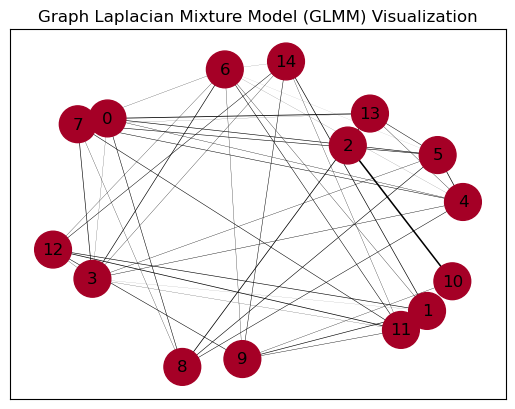

In [16]:

n = 15  
m = 150  
k = 2
zero_thresh = 10e-4

g = [generate_connected_graph(n, 0.7, zero_thresh) for _ in range(k)]

gamma = np.random.rand(m, 1)
gamma_cut = np.zeros((m, k))
dist = 0.5
p = np.linspace(0, 1, k + 1)
y = np.zeros((m, n))
true_y = np.zeros((m, n, k))
center = np.zeros((n, k))
gauss = np.zeros((n, n, k))
Lap = np.zeros((n, n, k))

for i in range(k):
    gc = pinv(g[i])
    gauss[:, :, i] = (gc + gc.T) / 2
    Lap[:, :, i] = g[i]
    center[:, i] = dist * np.random.randn(n)
    center[:, i] = center[:, i] - np.mean(center[:, i])
    gamma_cut[(p[i] < gamma[:, 0]) & (gamma[:, 0] <= p[i + 1]), i] = 1
    true_y[:, :, i] = gamma_cut[:, i][:, np.newaxis] * np.random.multivariate_normal(center[:, i], gauss[:, :, i], m)
    y += true_y[:, :, i]

iterations = 200
Ls, gamma_hats, mus, log_likelihood = glmm(y, iterations, k)
print('Training done')

print(np.sum(gamma_hats, axis=1))

identify, precision, recall, f, cl_errors ,NMI_score , num_of_edges = identify_and_compare(Ls, Lap, gamma_hats, gamma_cut, k)

print("Identify:", identify)
print("Precision:", precision)
print("Recall:", recall)
print("F-measure:", f)
print("Cluster Errors:", cl_errors)
print('Normalized mutual information', NMI_score)
print("Number of estimated edges", num_of_edges)
summed_gamma_hats = np.sum(gamma_hats, axis=1)
summed_gamma_hats_column = summed_gamma_hats[:, np.newaxis]
are_all_elements_one = np.allclose(summed_gamma_hats_column, 1, atol=1e-8)
print("\nAre all elements in the colum wise summed gamma_hat equal to 1:", are_all_elements_one)
visualize_glmm(Ls, gamma_hats)

In [6]:
import numpy as np

def glmm_matlab(y, iterations, classes, spread=0.1, regul=0.15, norm_par=1.5):
    """
    Python version of the MATLAB function glmm_matlab.

    Parameters
    ----------
    y : ndarray (m x n)
        Data matrix with m samples and n features.
    iterations : int
        Number of iterations.
    classes : int
        Number of classes (clusters).
    spread : float, optional
        Default 0.1
    regul : float, optional
        Default 0.15
    norm_par : float, optional
        Default 1.5

    Returns
    -------
    L : ndarray (n x n x classes)
        Graph Laplacians for each class.
    gamma_hat : ndarray (m x classes)
        Cluster posterior probabilities.
    mu : ndarray (n x classes)
        Cluster means.
    log_likelihood : ndarray (iterations,)
        Log-likelihood at each iteration.
    """

    # Helper constants
    delta = 2
    m, n = y.shape  # m samples, n features

    # Initialize arrays
    L = np.zeros((n, n, classes))
    W = np.zeros((n, n, classes))
    sigma = np.zeros((n-1, n-1, classes))
    mu = np.zeros((n, classes))
    gamma_hat = np.zeros((m, classes))
    p = np.zeros(classes)
    vecl = np.zeros((n, n, classes))
    vall = np.zeros((n, n, classes))
    yl = np.zeros((m, n-1, classes))

    # Initialization
    for class_idx in range(classes):
        L[..., class_idx] = spread * np.eye(n) - (spread / n) * np.ones((n, n))
        mu_curr = np.mean(y, axis=0) + np.random.randn(n) * np.std(y, axis=0)
        mu_curr = mu_curr - np.mean(mu_curr)
        mu[:, class_idx] = mu_curr
        p[class_idx] = 1.0 / classes

    log_likelihood = np.zeros(iterations)

    # Main loop
    for it in range(iterations):
        # Expectation step
        # putting everything in eigenvector space of dim-1
        pall = np.zeros(m)

        for class_idx in range(classes):
            # Eigen decomposition
            eigvals, eigvecs = np.linalg.eig(L[..., class_idx])
            # In MATLAB, [V,D] = eig(L) returns V as eigenvectors and D diag eigenvalues.
            # np.linalg.eig returns eigenvalues as a vector and eigenvectors as columns of eigvecs
            # We should ensure sorting if needed, but we'll assume identical behavior as MATLAB.
            # Let's store directly:
            vecl[..., class_idx] = eigvecs
            vall[..., class_idx] = np.diag(eigvals)

            # sigma = inv(vall(2:n,2:n,class) + regul*I)
            # We take the sub-block from index 1 to end (2:n in MATLAB means skipping the first eigenvalue)
            sub_eigvals = eigvals[1:]
            Sigma_inv = np.diag(sub_eigvals) + regul * np.eye(n-1)
            # inverse
            Sigma = np.linalg.inv(Sigma_inv)
            # Make symmetric
            Sigma = (Sigma + Sigma.T) / 2
            sigma[..., class_idx] = Sigma

            # yl = (y - mu(:,class)') * vecl(:,2:n,class)
            # mu[:,class_idx] is shape (n,)
            # y is (m,n), mu is (n,), we want (y - mu') => (m,n)
            # vecl(:,2:n,class_idx) => vecl[:,: ,class_idx], take from index 1 to n-1 for columns
            Y_centered = y - mu[:, class_idx]
            YL = Y_centered @ vecl[:, 1:, class_idx]
            yl[..., class_idx] = YL

            # pall = pall + p(class) * mvnpdf(yl(:,:,class), zeros(1,n-1), sigma(:,:,class))
            # We assume mvnpdf(yl, mean=0, cov=sigma) returns a vector of length m
            mvn_val = mvnpdf(YL, np.zeros(n-1), Sigma)
            pall += p[class_idx] * mvn_val

        # Avoid division by zero
        pall[pall == 0] = 0.1

        # compute gamma_hat
        for class_idx in range(classes):
            mvn_val = mvnpdf(yl[..., class_idx], np.zeros(n-1), sigma[..., class_idx])
            gamma_hat[:, class_idx] = (p[class_idx] * mvn_val) / pall

        # log-likelihood
        log_likelihood[it] = np.sum(np.log(pall))

        # Maximization step
        for class_idx in range(classes):
            # mu(:,class) = (gamma_hat(:,class)' * y) / sum(gamma_hat(:,class))
            wght = gamma_hat[:, class_idx]
            mu[:, class_idx] = (wght @ y) / np.sum(wght)

            # yc = sqrt(gamma_hat(:,class)) .* (y - mu(:,class)')
            # sqrt(gamma_hat(:,class)) is shape (m,)
            # (y - mu[:,class_idx]) is (m,n)
            # elementwise: we can do broadcast:
            yc = (y - mu[:, class_idx]) * np.sqrt(wght)[:, None]

            # Z = gsp_distanz(yc).^2
            Z = gsp_distanz(yc)
            Z = Z**2

            # theta = mean(Z(:))/norm_par
            theta = np.mean(Z) / norm_par

            # W_curr = delta*gsp_learn_graph_log_degrees(Z./theta, 1, 1)
            W_curr, _ = gsp_learn_graph_log_degrees(Z / theta, 1, 1, params={})
            W_curr = delta * W_curr

            p[class_idx] = np.sum(wght) / m

            # Compute L(:,:,class)
            # L = diag(sum(W)) - W
            W_sum = np.sum(W_curr, axis=1)
            L[..., class_idx] = np.diag(W_sum) - W_curr

            # W_curr(W_curr<1e-3)=0
            W_curr[W_curr < 1e-3] = 0
            W[..., class_idx] = W_curr

    return L, gamma_hat, mu, log_likelihood


In [8]:
import numpy as np
from scipy.stats import multivariate_normal
from math import log

def gsp_erdos_renyi(n, p):
    """
    Generate an Erdos-Renyi random graph G(n,p).
    Returns an object with L as the Laplacian matrix.
    """
    # Create adjacency matrix
    # For i < j, draw edge from Bernoulli(p)
    # Ensure no self loops and symmetric
    A = np.zeros((n, n))
    # Random upper-triangular edges
    upper = np.triu(np.random.rand(n, n) < p, 1)
    A = upper + upper.T  # symmetric adjacency

    # Degree matrix
    d = np.sum(A, axis=1)
    D = np.diag(d)

    # Laplacian
    L = D - A

    # Return a structure with L
    class Graph:
        pass
    g = Graph()
    g.L = L
    return g

def nmi(labels1, labels2):
    """
    Compute the normalized mutual information (NMI) between two label arrays.
    labels1 and labels2 are arrays of equal length with discrete assignments.

    NMI(X;Y) = 2*I(X;Y) / (H(X) + H(Y))
    """
    labels1 = np.asarray(labels1)
    labels2 = np.asarray(labels2)

    # Get unique classes and their frequencies
    # Joint distribution
    unique1 = np.unique(labels1)
    unique2 = np.unique(labels2)

    # Construct joint frequency table
    N = len(labels1)
    contingency = np.zeros((len(unique1), len(unique2)))
    for i, c1 in enumerate(unique1):
        for j, c2 in enumerate(unique2):
            contingency[i, j] = np.sum((labels1 == c1) & (labels2 == c2))

    # Joint probability
    Pxy = contingency / N

    # Marginal probabilities
    Px = Pxy.sum(axis=1)
    Py = Pxy.sum(axis=0)

    # Compute entropies
    def entropy(prob):
        prob = prob[prob > 0]
        return -np.sum(prob * np.log(prob))

    Hx = entropy(Px)
    Hy = entropy(Py)

    # Mutual information I(X;Y)
    # I(X;Y) = sum_x,y P(x,y)*log(P(x,y)/(P(x)*P(y)))
    # Only sum where Pxy > 0
    Pxy_nonzero = Pxy[Pxy > 0]
    # corresponding Px,Py:
    # We need indices from Pxy to match Px,Py
    # Easier way: double loop or vectorized log:
    I = 0.0
    for i in range(len(unique1)):
        for j in range(len(unique2)):
            if Pxy[i, j] > 0:
                I += Pxy[i, j] * np.log(Pxy[i, j] / (Px[i]*Py[j]))

    # NMI
    denominator = (Hx + Hy)
    if denominator == 0:
        return 1.0 if I == 0 else 0.0
    NMI = 2*I/denominator
    return NMI

def mvnpdf(X, mean, cov):
    """
    Evaluate multivariate normal pdf.
    X: (m, d)
    mean: (d,)
    cov: (d,d)
    Returns pdf values: (m,)
    """
    X = np.asarray(X)
    mean = np.asarray(mean)
    cov = np.asarray(cov)
    rv = multivariate_normal(mean=mean, cov=cov)
    return rv.pdf(X)


In [9]:
import numpy as np
from scipy.spatial.distance import squareform
# Assume the following functions are defined and behave like in MATLAB:
# glmm_matlab(y, iterations, k)
# gsp_erdos_renyi(n, p) - returns a graph structure with attribute 'L' for Laplacian
# nmi(labels1, labels2)
# gsp_distanz(X)
# gsp_learn_graph_log_degrees(Z, a, b, params)
# mvnpdf(X, mean, cov) - returns probability densities

def graph_learning_perf_eval(L_0, L):
    # Evaluate the performance of graph learning algorithms
    L_0tmp = L_0 - np.diag(np.diag(L_0))
    edges_groundtruth = (squareform(L_0tmp) != 0)

    Ltmp = L - np.diag(np.diag(L))
    edges_learned = (squareform(Ltmp) != 0)

    # Compute precision, recall
    # True Positive (TP): edge is in groundtruth and learned
    TP = np.sum(edges_learned & edges_groundtruth)
    FP = np.sum(edges_learned & (~edges_groundtruth))
    FN = np.sum((~edges_learned) & edges_groundtruth)

    if (TP + FP) == 0:
        precision = 0.0
    else:
        precision = TP / (TP + FP)
    if (TP + FN) == 0:
        recall = 0.0
    else:
        recall = TP / (TP + FN)

    # F-measure
    if (precision + recall) == 0:
        f = 0.0
    else:
        f = 2 * precision * recall / (precision + recall)

    # NMI - convert boolean arrays to integers
    # NMI expects labels or cluster assignments. We'll treat edges as binary labels.
    NMI_score = nmi(edges_learned.astype(int), edges_groundtruth.astype(int))
    if np.isnan(NMI_score):
        NMI_score = 0.0

    # number of edges in the learned graph
    num_of_edges = np.sum(edges_learned)

    return precision, recall, f, NMI_score, num_of_edges


def identify_and_compare(Ls, Lap, gamma_hats, gamma_cut, k):
    identify = np.zeros(k, dtype=int)
    cl_err = np.inf * np.ones(k)
    for i in range(k):
        # Make W from L
        W = np.diag(np.diag(Ls[:, :, i])) - Ls[:, :, i]
        W[W < 0.001] = 0
        Ls[:, :, i] = np.diag(np.sum(W, axis=1)) - W
        # Find best matching cluster j
        for j in range(k):
            er = np.linalg.norm(gamma_hats[:, i] - gamma_cut[:, j], 'fro')
            if cl_err[i] > er:
                cl_err[i] = er
                identify[i] = j

    precision = np.zeros((k, 1))
    recall = np.zeros((k, 1))
    f = np.zeros((k, 1))
    for i in range(k):
        p, r, ff, NMI_score, num_edges = graph_learning_perf_eval(Lap[:, :, identify[i]], Ls[:, :, i])
        precision[i] = p
        recall[i] = r
        f[i] = ff
        # NMI_score and num_edges are not stored as per original code except NMI in a local var.
        # If needed, store them similarly.

    cl_errors = np.diag((gamma_hats - gamma_cut[:, identify]) \
                        .T @ (gamma_hats - gamma_cut[:, identify]))
    return identify, precision, recall, f, cl_errors


# Main script
if __name__ == "__main__":
    np.random.seed(0)
    n = 15  # graph size
    m = 150 # number of signals
    k = 2   # number of clusters
    zero_thresh = 1e-3

    # generate graphs
    # We'll try until we get connected graphs as per MATLAB code
    def generate_connected_erdos_renyi(n, p=0.7, zero_thresh=1e-3):
        while True:
            g = gsp_erdos_renyi(n, p)
            eigs = np.sort(np.linalg.eigvalsh(g.L))
            # ensuring graph is connected
            if eigs[1] > zero_thresh:
                return g

    g_list = [generate_connected_erdos_renyi(n, 0.7, zero_thresh) for _ in range(k)]

    gamma = np.random.rand(m, 1)
    gamma_cut = np.zeros((m, k))
    dist = 0.5
    p_arr = np.linspace(0, 1, k+1)

    y = np.zeros((m, n))
    true_y = np.zeros((m, n, k))
    center = np.zeros((n, k))
    gauss = np.zeros((n, n, k))
    Lap = np.zeros((n, n, k))

    for i in range(k):
        gc = np.linalg.pinv(g_list[i].L)
        gauss[:, :, i] = (gc + gc.T) / 2
        Lap[:, :, i] = g_list[i].L
        center[:, i] = dist * np.random.randn(n)
        center[:, i] = center[:, i] - np.mean(center[:, i])
        # Assign responsibilities
        gamma_cut[(p_arr[i]<gamma) & (gamma<=p_arr[i+1]), i] = 1
        # Generate data
        # mvnrnd(center(:,i), gauss(:,:,i), m)
        # means shape: (n,)
        # covariance shape: (n,n)
        Y_i = np.random.multivariate_normal(center[:, i], gauss[:, :, i], m)
        Y_i = Y_i * gamma_cut[:, i][:, None]  # scale by responsibilities
        true_y[:, :, i] = Y_i
        y = y + Y_i

    # train a glmm on data y
    iterations = 200
    Ls, gamma_hats, mus, log_likelihood = glmm_matlab(y, iterations, k)
    print("Training done")

    print(np.sum(gamma_hats, axis=0))

    identify, precision, recall, f, cl_errors = identify_and_compare(Ls, Lap, gamma_hats, gamma_cut, k)
    print("identify:", identify)
    print("precision:", precision)
    print("recall:", recall)
    print("f:", f)
    print("cl_errors:", cl_errors)


IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [7]:
def test_glmm_matlab():
    # Create synthetic data
    np.random.seed(0)
    m = 10  # samples
    n = 5   # features
    y = np.random.randn(m, n)
    iterations = 5
    classes = 2

    # Assuming all required functions (mvnpdf, gsp_distanz, gsp_learn_graph_log_degrees)
    # are defined and produce identical results to MATLAB counterparts.
    L, gamma_hat, mu, log_likelihood = glmm_matlab(y, iterations, classes)

    # We can check basic properties:
    assert L.shape == (n, n, classes), "L shape mismatch"
    assert gamma_hat.shape == (m, classes), "gamma_hat shape mismatch"
    assert mu.shape == (n, classes), "mu shape mismatch"
    assert len(log_likelihood) == iterations, "log_likelihood length mismatch"

    # Check that no NaNs:
    assert not np.isnan(L).any(), "NaN in L"
    assert not np.isnan(gamma_hat).any(), "NaN in gamma_hat"
    assert not np.isnan(mu).any(), "NaN in mu"
    assert not np.isnan(log_likelihood).any(), "NaN in log_likelihood"

    # Without the exact MATLAB results, we can just ensure it runs and shapes are correct
    print("Test passed: glmm_matlab ran successfully with given input.")

# Run test
test_glmm_matlab()


ValueError: Array 'mean' must be a vector of length 40.